In [1]:
import numpy as np
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro

# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y~X1+X2+...)
import statsmodels.formula.api as smf
# Scaling 클래스
from sklearn.preprocessing import scale, minmax_scale, robust_scale
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 선형회귀모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse
# Ridge, Lasso, ElasticNet 패키지 불러오기
from sklearn.linear_model import Ridge, Lasso, ElasticNet
# 데이터 분할: train, test
from sklearn.model_selection import train_test_split
# 예측/회귀 Decision Tress
from sklearn.tree import DecisionTreeRegressor
# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestRegressor
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# export_graphviz: 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화(.dot 확장자 파일 불러오기 등)
import graphviz
# MSE 계산
from sklearn.metrics import mean_squared_error
# MAE 계산
from sklearn.metrics import mean_absolute_error
# 예측/회귀 Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# jupyter notebook 사용 시 그래프 자동 출력 옵션
# matplotlib 이용한 Background 그래프 실행 및 결과 확인
%matplotlib inline

# 음수 표시
plt.rc('axes', unicode_minus=False)
# 맑은 고딕 적용
plt.rc("font", family="Malgun Gothic")

# 그래디언트 부스팅
콘크리트 강도는 예측하는 그래디언트 부스팅 모델을 만들고 predict method를 이용하여 예측값을 구하라.  
그리고 모델의 mse와 mae를 산출하여 비교하라.  
- 데이터 : Concrete.CSV(변수: 9개, 자료 수: 1,030개)
- 목표변수 : strength
- 데이터는 (train(0.6) : test(0.4))의 비율로 분할 (train_test_split 활용)
1. train 데이터: 모델 훈련
2. test 데이터 : 1에서 개발한 모델의 성능 평가

|변수|변수 설명|변수 역할|변수 형태|
|---|---|---|---|
|cement|시멘트|설명변수|연속형|
|blast_furnace_slag|고로슬래그|설명변수|연속형|
|fly_ash|연소분말|설명변수|연속형|
|water|수분|설명변수|연속형|
|superplasticizer|유동화제|설명변수|연속형|
|coarse_aggregate|굵은골재|설명변수|연속형|
|fine_aggregate|잔골재|설명변수|연속형|
|age|재령|설명변수|연속형|
|strength|강도|목표변수|연속형|

## 1. 데이터 구성하기

In [2]:
# 파일명, 변수, 값 등에 한글 포함시 engine="python" 지정
df_raw=pd.read_csv("../data/Concrete.csv", engine="python")
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw["strength"]
df_raw_x=df_raw.drop("strength", axis=1, inplace = False)

In [4]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.4, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (618, 8)
train data Y size : (618,)
test data X size : (412, 8)
test data Y size : (412,)


## 2. 모델 생성 및 Parameter 조정

In [5]:
# 모델 생성 : GradientBoostingRegressor
gb_uncustomized=GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.951
Score on test set: 0.915


> 모델 설명력은 train 95.1%, test 91.5%로 모델은 일반화된 모델이라고 할 수 있다.

- n_estimators: 트리 수 변경에 따른 모델 성능

In [6]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_tree: 잎사귀 최소 자료 수
para_n_tree=[n_tree*10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_n=pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["TestScore"]=test_score

In [7]:
# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.646,0.621
1,20,0.807,0.773
2,30,0.870,0.835
3,40,0.898,0.863
4,50,0.915,0.878
5,60,0.925,0.888
6,70,0.934,0.898
7,80,0.940,0.904
8,90,0.946,0.910
9,100,0.951,0.915


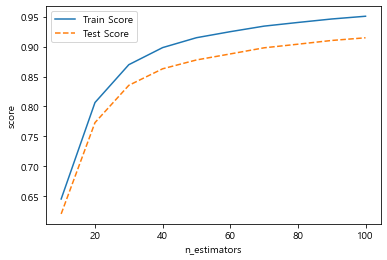

In [8]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

> 트리 수 증가에 따라 모델의 설명력은 지속적으로 향상되고 있으나  
> 과적합을 방지를 고려하여 50 선택

- min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [9]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=50, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

In [10]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.915,0.878
1,2,0.914,0.877
2,3,0.911,0.876
3,4,0.911,0.878
4,5,0.912,0.878
5,6,0.910,0.880
6,7,0.910,0.878
7,8,0.911,0.879
8,9,0.909,0.881
9,10,0.907,0.876


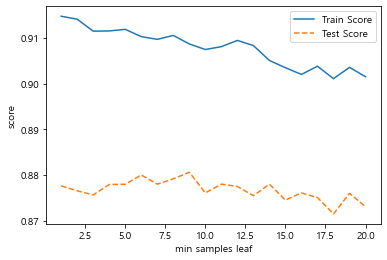

In [11]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

> 데이터의 성능 변화를 고려하여 9 선택

- min_sample_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [12]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_split: 잎사귀 최소 자료 수
para_split=[n_split*2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=50, min_samples_leaf=9,
                             min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score

In [13]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.909,0.881
1,6,0.909,0.881
2,8,0.909,0.881
3,10,0.909,0.881
4,12,0.909,0.881
5,14,0.909,0.881
6,16,0.909,0.881
7,18,0.909,0.881
8,20,0.910,0.882
9,22,0.908,0.879


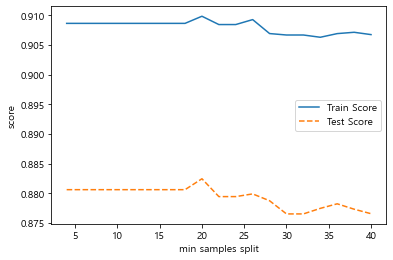

In [14]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

> Train/test 데이터의 성능 변화를 고려하여 20 선택  

- max_depth: 최대 깊이 변경에 따른 모델 성능

In [15]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_depth: 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=50, min_samples_leaf=9,
                             min_samples_split=20, max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth=pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score

In [16]:
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.715,0.692
1,2,0.862,0.836
2,3,0.910,0.882
3,4,0.940,0.900
4,5,0.960,0.908
5,6,0.968,0.920
6,7,0.976,0.924
7,8,0.978,0.922
8,9,0.980,0.925
9,10,0.980,0.924


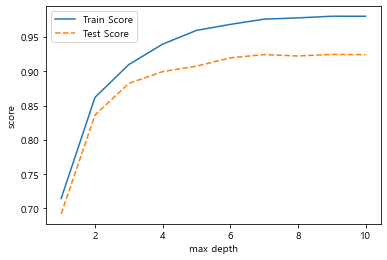

In [17]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

> 최대 깊이 증가에 따라 모델의 설명력은 증가하며  
> train 데이터의 성능 변화를 고려하여 7 선택

- learning_rate: 학습률 변경에 따른 모델 성능

In [18]:
# train 및 test 설명력 결과 저장
train_score=[]; test_score=[]
# min_samples_lr: 잎사귀 최소 자료 수
para_lr=[lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb=GradientBoostingRegressor(random_state=1234, n_estimators=50, min_samples_leaf=9,
                             min_samples_split=20, max_depth=7, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_lr=pd.DataFrame()
df_score_lr["LearningRate"]=para_lr
df_score_lr["TrainScore"]=train_score
df_score_lr["TestScore"]=test_score

In [19]:
# 모델 설명력 확인
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.976,0.924
1,0.2,0.985,0.930
2,0.3,0.989,0.930
3,0.4,0.991,0.929
4,0.5,0.992,0.930
5,0.6,0.993,0.924
6,0.7,0.994,0.908
7,0.8,0.994,0.894
8,0.9,0.994,0.887


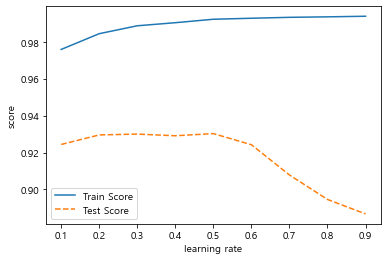

In [20]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle="-", label="Train Score")
plt.plot(para_lr, test_score, linestyle="--", label="Test Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()

> test 데이터의 성능은 급격하게 저하되기 직전 0.5 선택  

## 3. 결론 도출

In [21]:
# 최종 모델
gb_final=GradientBoostingRegressor(random_state=1234, n_estimators=50, min_samples_leaf=9,
                             min_samples_split=20, max_depth=7, learning_rate=0.5)
gb_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.992
Score on test set: 0.930


> 모델 설명력은 train 99.2%, test 93%로 모델은 일반화된 모델이라고 할 수 있다.

# 예측값을 구하고 MSE / MAE 비교

In [22]:
# 예측값
y_pred = gb_final.predict(df_test_x)

# MSE / MAE
print("MSE :", mean_squared_error(df_test_y, y_pred))
print("MAE :", mean_absolute_error(df_test_y, y_pred))

MSE : 18.88857227389879
MAE : 3.073878919300082


> 위 모델을 사용하여 예측하였을 때,  
> MSE = 18.89 / MAE = 3.07 로 약간의 잔차가 있다.

In [23]:
# 변수명 저장
v_feature_name=df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,age,0.340
0,cement,0.246
3,water,0.175
4,superplasticizer,0.085
1,blast_furnace_slag,0.051
6,fine_aggregate,0.051
5,coarse_aggregate,0.028
2,fly_ash,0.023


Text(0, 0.5, '변수')

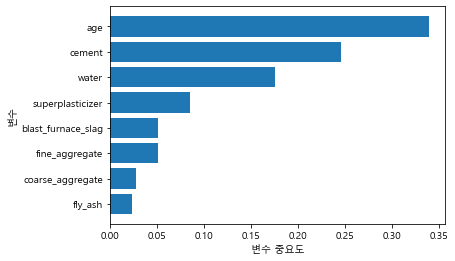

In [24]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

>**[결론]**  
> 중요 설명변수:
>재령(age), 시멘트(cement), water(수분) 순으로 영향이 크다고 해석할 수 있음  

- GridSearchCV를 이용한 최적의 parameter를 찾는 것은 너무 오래걸려서 넘어가겠습니다.

In [25]:
# estimator=GradientBoostingRegressor(random_state=1234)
# # 구하고자 하는 parameter와 범위
# param_grid={"criterion":["mse", "friedman_mse", "mae"], "max_features" : ["auto", "sqrt", "log2"], 
#             "learning_rate":para_lr, "max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}
# # 설명력이 높은 최적 parameter 찾기
# grid_gb = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
# grid_gb.fit(df_train_x, df_train_y)

# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_gb.best_params_))
# print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))